In [1]:
from typing import Any

import clickhouse_connect
import pandas as pd

from service.config import config
from service.record import LogRecord
from service.geoip import find_location, find_location_2

# 1. Подключение к базе данных

In [2]:
client = clickhouse_connect.get_client(
    host=config['DBHOST'],
    username=config['DBUSER'],
    password=config['DBPWD'],
    port=config['DBPORT'],
    database='helloworld',
)

### 1.1. Пример запроса создания новой таблицы

In [ ]:
client.command("""CREATE TABLE helloworld.ip_geo
(
    ip String,
    geo String   
)
ENGINE = MergeTree()
PRIMARY KEY (ip)
""")

### 1.2. Пример запроса добавления колонки в созданную ранее таблицу

In [ ]:
client.command('ALTER TABLE helloworld.auth_log ADD COLUMN ip_geo String AFTER ip')

### 1.3. Пример запроса для получения наименований столбцов таблицы

In [3]:
columns = client.query("select column_name from information_schema.columns where table_schema = 'helloworld' order by table_name, ordinal_position")
columns_name = [col[0] for col in columns.result_rows[:9]]

In [ ]:
join_query = client.query("SELECT COLUMN_NAME, IS_NULLABLE, DATA_TYPE, CHARACTER_MAXIMUM_LENGTH FROM information_schema.columns WHERE table_name = 'ip_geo'")
join_query.result_rows

In [4]:
columns_name

['rec_date',
 'vm',
 'auth_service',
 'body',
 'accept',
 'ip',
 'ip_geo',
 'target_user',
 'target_port']

# 2. Заполняем базовую таблицу попыток авторизации

In [ ]:
def get_records(num: int) -> list[list[Any]]: 
    with open(f'data_auth/auth_{num}.log', 'r') as log:
        data = log.readlines()
    return [LogRecord(row).to_list() for row in data]

for num in range(7):
    print(f'read auth_{num}.log file')
    records = get_records(num)
    print(f'insert auth_{num}.log file')
    client.insert('auth_log', records, column_names=columns_name)

# 3. Формируем таблицу соответствия ip и страны

## 3.1. Запрос к базе на весь перечень ip адресов

В данном случае код python по последующей обработке можно было и не применять. Все операции возможно было сделать в запросе к базе (группировка, фильтрация, сортировка)

In [ ]:
ip_adress = client.query("SELECT ip FROM auth_log WHERE ip <> ''")
ip_df = pd.DataFrame(ip_adress.result_rows, columns=['ip'])
ip_df = ip_df.drop_duplicates()
list_ip = [[ip] for ip in ip_df['ip'].to_list()]
list_ip.sort()

## 3.2. Запись даных ip адресов в таблицу

In [ ]:
client.insert('ip_geo', list_ip, column_names=['ip'])

## 3.3 Поиск страны по соответствующему ip и запись в таблицу (в данном случае используем бесплатный ресурс)

In [ ]:
for ip in list_ip:
    print(ip[0])
    geo = find_location_2(ip[0])
    client.query(f"ALTER TABLE helloworld.ip_geo UPDATE geo='{geo}' where ip='{ip[0]}'")

## 3.4. Используем платный ресурс для записи стран которые не были найдены ранее

### 3.4.1 Извлекаем ip с отсутствующими названиями

In [ ]:
not_found = client.query("""
SELECT table.ip FROM helloworld.ip_geo as table WHERE table.geo = 'Not found'
""")
not_found_list = [ip[0] for ip in not_found.result_rows]

### 3.4.2. Запускаем платный ресурс для записи

In [ ]:
for ip in not_found_list:
    print(ip)
    geo = find_location(ip)
    geo = geo.replace("'", "_")
    if geo == 'Côte dIvoire':
        geo = 'Cote dIvoire'   
    client.query(f"ALTER TABLE helloworld.ip_geo UPDATE geo='{geo}' where ip='{ip}'")

# 4. Примеры отчетов

In [54]:
import matplotlib.pyplot as plt

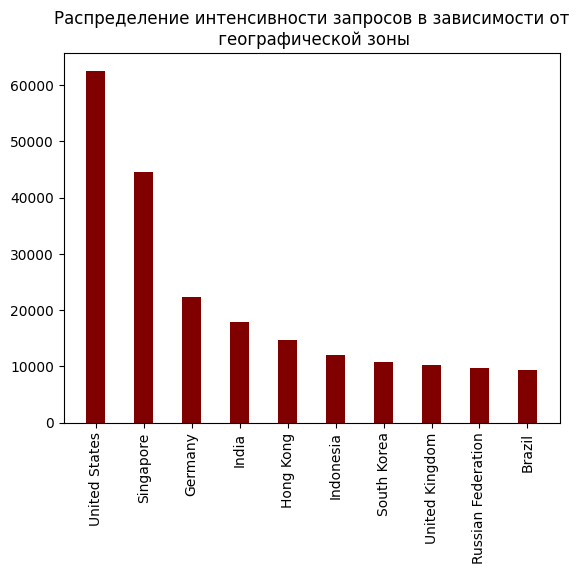

In [62]:
tmp_query = client.query("SELECT ipgeo.geo, count(ipgeo.geo) FROM helloworld.auth_log as auth LEFT OUTER JOIN helloworld.ip_geo as ipgeo ON auth.ip = ipgeo.ip WHERE auth.ip <> '' GROUP BY ipgeo.geo ORDER BY count(ipgeo.geo) DESC")
zone_df = pd.DataFrame(tmp_query.result_rows, columns=['country', 'count'])
xlabel = zone_df['country'][:10].to_list()
ylabel = zone_df['count'][:10].to_list()
plt.title('Распределение интенсивности запросов в зависимости от\n географической зоны')
plt.bar(xlabel, ylabel, color ='maroon', width = 0.4)
plt.xticks(fontsize=10, rotation=90)
plt.show()

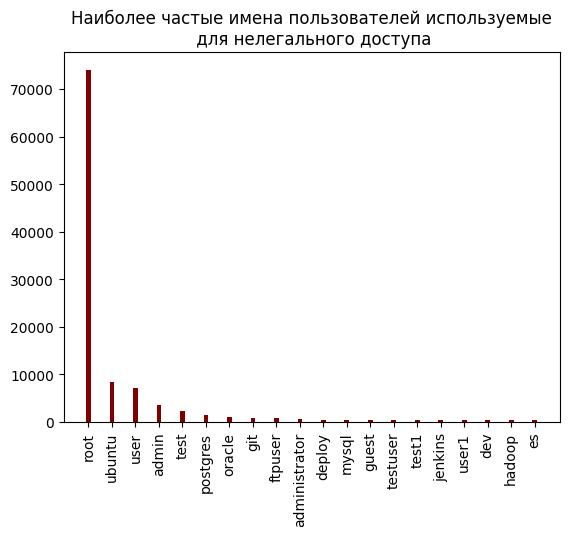

In [68]:
tmp_query = client.query("SELECT target_user, count(target_user) FROM helloworld.auth_log WHERE target_user <> '' GROUP BY target_user ORDER BY count(target_user) DESC")
tmp_query.result_rows
user_df = pd.DataFrame(tmp_query.result_rows, columns=['user', 'count'])
xlabel = user_df['user'][:20].to_list()
ylabel = user_df['count'][:20].to_list()
plt.title('Наиболее частые имена пользователей используемые\n для нелегального доступа')
plt.bar(xlabel, ylabel, color ='maroon', width = 0.2)
plt.xticks(fontsize=10, rotation=90)
plt.show()

## Очистка таблиц

In [ ]:
client.query('TRUNCATE TABLE ip_geo')